In [15]:
!pip install anthropic
!pip install beautifulsoup4
!pip install requests
!pip install selenium
!pip install webdriver-manager


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Setup your own API key
* Login & setup your API key from here (https://console.anthropic.com/settings/keys)
* Paste your API key in the following inverted commas

In [ ]:
import os
# Set the environment variable within the notebook
os.environ["ANTHROPIC_API_KEY"] = ""

***Following code is just a sample, your task is to encapsulate this code in a function with arguments of your choice so that function can be reused***

#### Following link is for reference: https://docs.anthropic.com/en/docs/initial-setup#next-steps

In [2]:
import json
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
driver=webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
base_url='https://www.opentable.com/r/kitchen-and-kocktails-by-kevin-kelley-dc-washington?originId=ad509d53-be42-40df-b7bd-9a8f6c1b45c4&corrid=ad509d53-be42-40df-b7bd-9a8f6c1b45c4&avt=eyJ2IjoyLCJtIjoxLCJwIjoxLCJzIjowLCJuIjowfQ&page='
reviews_data=[]
page_number=1
while True:
    try:
        url=f"{base_url}{page_number}"
        driver.get(url)
        time.sleep(3) 
        soup=BeautifulSoup(driver.page_source,'html.parser')
        reviews_list=soup.find_all('li',class_='afkKaa-4T28-')
        restaurant_name = soup.find('h1',class_='E-vwXONV9nc-').text.strip()
        if not reviews_list:
            raise Exception("No reviews found on this page.")
        for review in reviews_list:
            ratings={
                li.text.split()[0]:li.find('span',class_='-y00OllFiMo-').text
                for li in review.find_all('li',class_='-k5xpTfSXac-')
            }
            review_data={
                'restaurant_name':restaurant_name,
                "name":review.find('p',class_='_1p30XHjz2rI-').text if review.find('p',class_='_1p30XHjz2rI-') else 'No Name',
                "location":review.find('p',class_='POyqzNMT21k-').text if review.find('p',class_='POyqzNMT21k-') else 'No Location',
                "overall":ratings.get("Overall","No Rating"),
                "food":ratings.get("Food","No Rating"),
                "Service":ratings.get("Service","No ratings"),
                "Ambience":ratings.get("Ambience","No ratings"),
                "date":review.find('p',class_='iLkEeQbexGs-').text if review.find('p',class_='iLkEeQbexGs-') else 'No Date',
                "review_text":review.find('span',class_='l9bbXUdC9v0-').text if review.find('span',class_='l9bbXUdC9v0-') else 'No Review Text',
            }
            reviews_data.append(review_data)
        page_number+=1
        if page_number>161:
            break
    except Exception as e:
        print(f"Error:{e}")
        break
with open("reviews.json","w",encoding="utf-8") as file:
    json.dump(reviews_data,file,ensure_ascii=False,indent=4)
driver.quit()

In [ ]:
from groq import Groq
import os
import json
os.environ['GROQ_API_KEY']=''
client=Groq(api_key=os.environ.get("GROQ_API_KEY"))
def categorize_review(review_text):
    system_message=(
        "You are a review analysis assistant. Your task is to extract comments "
        "related to food quality and staff/service from restaurant reviews.\n\n"
        "Follow these guidelines strictly:\n"
        "1. Extract Only Relevant Information: Include only text related to food quality and staff/service.\n"
        "2. Preserve Original Text: Do not alter the text in any way.\n"
        "3. Exclude Personal Information: Omit reviewer or staff names, locations, or contact details.\n"
        "4. No Added Content: Do not include extra interpretation or explanation.\n"
        "5. If nothing related to food or staff/service exists, return empty lists DO NOT give NONE or anyother thing."
    )
    user_message=(
        f"""
        Extract details from the following restaurant review into these categories:\n
        - **Food Quality:** Mention comments about food, taste, preparation, and presentation.\n
        - **Staff/Service:** Mention comments about staff behavior, service speed, and attitude.\n
        Do not include personal information like reviewer names, locations, or contacts.\n
        Review: "{review_text}"\n
        Provide results **only** in this JSON format, **DO NOT** add anything extra:\n
        {{
            "review_text": "{review_text}",
            "food_quality": ["Extracted comments about food."],
            "staff_service": ["Extracted comments about staff or service."]
        }}
        """
    )
    response=client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ]
    )
    response_text=response.choices[0].message.content
    print(response_text)
    return json.loads(response_text)
processed_count=0
with open("extracted_reviews.json","w",encoding="utf-8") as file:
    file.write("[")
    for idx,review in enumerate(reviews_data):
        try:
            text=review.get("review_text","")
            result=categorize_review(text)
            if idx>0:
                file.write(",\n")
            json.dump(result,file,ensure_ascii=False,indent=4)
            processed_count+=1
            print(f"Processed reviews: {processed_count}")
        except Exception as e:
            print(f"Error processing review: {review}\nError: {e}")
    file.write("\n]")
print("Review extraction complete. Data saved to 'extracted_reviews.json'.")

{
    "review_text": "The food was outstanding and the restaurant is beautiful.  Unfortunately our server was extremely busy and we waited for our dessert order for over 30 minutes.  We ended up canceling the order because of the delay.",
    "food_quality": ["The food was outstanding"],
    "staff_service": ["our server was extremely busy", "We waited for our dessert order for over 30 minutes", "We ended up canceling the order because of the delay"]
}
Processed reviews: 1
{
  "review_text": "Great service, food and drinks!! The ambiance is a vibe!",
  "food_quality": ["food and drinks!!"],
  "staff_service": ["Great service"]
}
Processed reviews: 2
{
    "review_text": "Food was very good. Service was a little slow especially since we went early in the week and there was hardly anyone in the restaurant but overall we had a great time and food was delicious.",
    "food_quality": ["Food was very good. Food was delicious."],
    "staff_service": ["Service was a little slow"]
}
Processed

KeyboardInterrupt: 

In [ ]:
import anthropic
import json
client=anthropic.Anthropic()
def categorize_review(review_text):
    message=client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1000,
        temperature=0,
        system="""You are a review analysis assistant.Your task is to extract comments related to food quality and staff/service from review text.
        Follow these guidelines strictly\n:
        Extract Only Relevant Information: Include only text related to food quality and staff/service\n.
        Preserve Original Text: Do not alter the text in any way. Maintain original casing, spacing, punctuation, and formatting\n.
        Exclude Personal Information: Omit personal details such as reviewer or staff names, locations, or contact information\n.
        No Added Content: Do not include any additional interpretation or explanation of your own\n.
        If there is nothing related to food or staff/service in the review return empty lists in food_quality and staff_service\n.""",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type":"text",
                        "text":f"""
                        Extract details from the following restaurant review into these categories\n:
                        - **Food Quality:** Mention comments about food, taste, preparation, and presentation\n.
                        - **Staff/Service:** Mention comments about staff behavior, service speed, and attitude\n.
                        Do not include personal information like reviewer names, locations, or contacts\n.
                        Review:"{review_text}"\n
                        Provide results **only** in this JSON format,**DO NOT** give anything extra\n,
                        {{
                            "food_quality":["Extracted comments about food."],
                            "staff_service":["Extracted comments about staff or service."]
                        }}
                        """
                    }
                ]
            }
        ]
    )
    print(message.content[0].text)
    return json.loads(message.content[0].text)
extracted_data=[]
for review in reviews_data:
    try:
        text=review.get("review_text","")
        result=categorize_review(text)
        extracted_data.append(result)
    except Exception as e:
        print(f"Error processing review:{review}\nError:{e}")
with open("extracted_reviews.json","w",encoding="utf-8") as file:
    json.dump(extracted_data,file,ensure_ascii=False,indent=4)
print("Review extraction complete. Data saved to 'extracted_reviews.json'.")

In [6]:
import json
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
url=input("Enter the url of competitor restaurant:")
driver=webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
base_url=url[:-1]
reviews_data=[]
page_number=1
while True:
    try:
        url=f"{base_url}{page_number}"
        driver.get(url)
        time.sleep(3) 
        soup=BeautifulSoup(driver.page_source,'html.parser')
        reviews_list=soup.find_all('li',class_='afkKaa-4T28-')
        restaurant_name = soup.find('h1',class_='E-vwXONV9nc-').text.strip()
        if not reviews_list:
            raise Exception("No reviews found on this page.")
        for review in reviews_list:
            ratings={
                li.text.split()[0]:li.find('span',class_='-y00OllFiMo-').text
                for li in review.find_all('li',class_='-k5xpTfSXac-')
            }
            review_data={
                'restaurant_name':restaurant_name,
                "name":review.find('p',class_='_1p30XHjz2rI-').text if review.find('p',class_='_1p30XHjz2rI-') else 'No Name',
                "location":review.find('p',class_='POyqzNMT21k-').text if review.find('p',class_='POyqzNMT21k-') else 'No Location',
                "overall":ratings.get("Overall","No Rating"),
                "food":ratings.get("Food","No Rating"),
                "Service":ratings.get("Service","No ratings"),
                "Ambience":ratings.get("Ambience","No ratings"),
                "date":review.find('p',class_='iLkEeQbexGs-').text if review.find('p',class_='iLkEeQbexGs-') else 'No Date',
                "review_text":review.find('span',class_='l9bbXUdC9v0-').text if review.find('span',class_='l9bbXUdC9v0-') else 'No Review Text',
            }
            reviews_data.append(review_data)
        page_number+=1
        if page_number>219:
            break
    except Exception as e:
        print(f"Error:{e}")
        break
with open("competitor_reviews.json","w",encoding="utf-8") as file:
    json.dump(reviews_data,file,ensure_ascii=False,indent=4)
driver.quit()

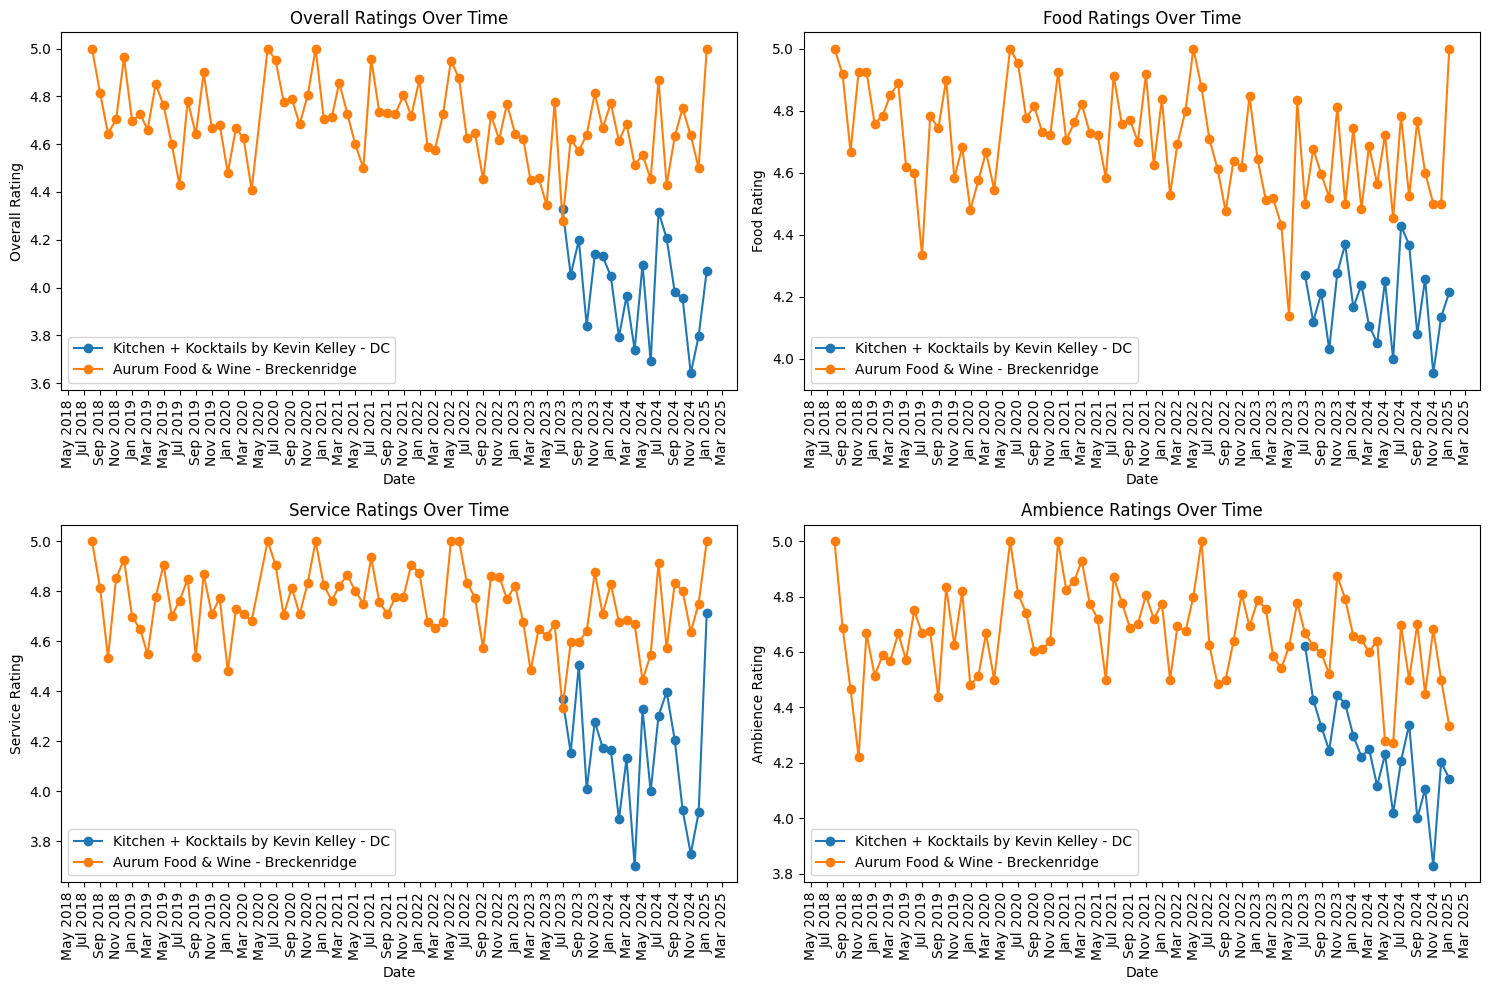

In [14]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def load_json(file_path):
    with open(file_path,"r",encoding="utf-8") as file:
        return json.load(file)
data1=load_json('reviews.json')
data2=load_json('competitor_reviews.json')
check=pd.DataFrame(data2)
competitor_name=check.loc[0,'restaurant_name']
data=data1+data2
def parse_date(date_string):
    if "today" in date_string:
        return datetime.today().date()
    elif "days ago" in date_string:
        days_ago=int(date_string.split(" ")[1])
        return (datetime.today()-pd.Timedelta(days=days_ago)).date()
    elif "Dined on" in date_string:
        return datetime.strptime(date_string,"Dined on %B %d, %Y").date()
df=pd.DataFrame(data)
df['date']=pd.to_datetime(df['date'].apply(parse_date))
df['overall']=pd.to_numeric(df['overall'],errors='coerce')
df['food']=pd.to_numeric(df['food'],errors='coerce')
df['Service']=pd.to_numeric(df['Service'],errors='coerce')
df['Ambience']=pd.to_numeric(df['Ambience'],errors='coerce')
grouped_data=df.groupby(['restaurant_name',pd.Grouper(key='date',freq='ME')]).agg({
    'overall': 'mean','food': 'mean','Service': 'mean','Ambience': 'mean'}).reset_index()
fig,axes=plt.subplots(2,2,figsize=(15,10))
restaurants=['Kitchen + Kocktails by Kevin Kelley - DC',competitor_name]
def plot_data(ax,metric,title,ylabel):
    for restaurant in restaurants:
        data=grouped_data[grouped_data['restaurant_name']==restaurant]
        ax.plot(data['date'],data[metric],label=restaurant,marker='o')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x',rotation=90)
plot_data(axes[0,0],'overall',"Overall Ratings Over Time","Overall Rating")
plot_data(axes[0,1],'food',"Food Ratings Over Time","Food Rating")
plot_data(axes[1,0],'Service',"Service Ratings Over Time","Service Rating")
plot_data(axes[1,1],'Ambience',"Ambience Ratings Over Time","Ambience Rating")
plt.tight_layout()
plt.show()